In [2]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

#### Load Anndata

In [3]:
# data directory and files for pre-prared anndata
data_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/'
all_samples_path = os.path.join(data_dir, 'aging_all/objects/major_celltype_seurat.h5ad')

AnnData object with n_obs × n_vars = 40106 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


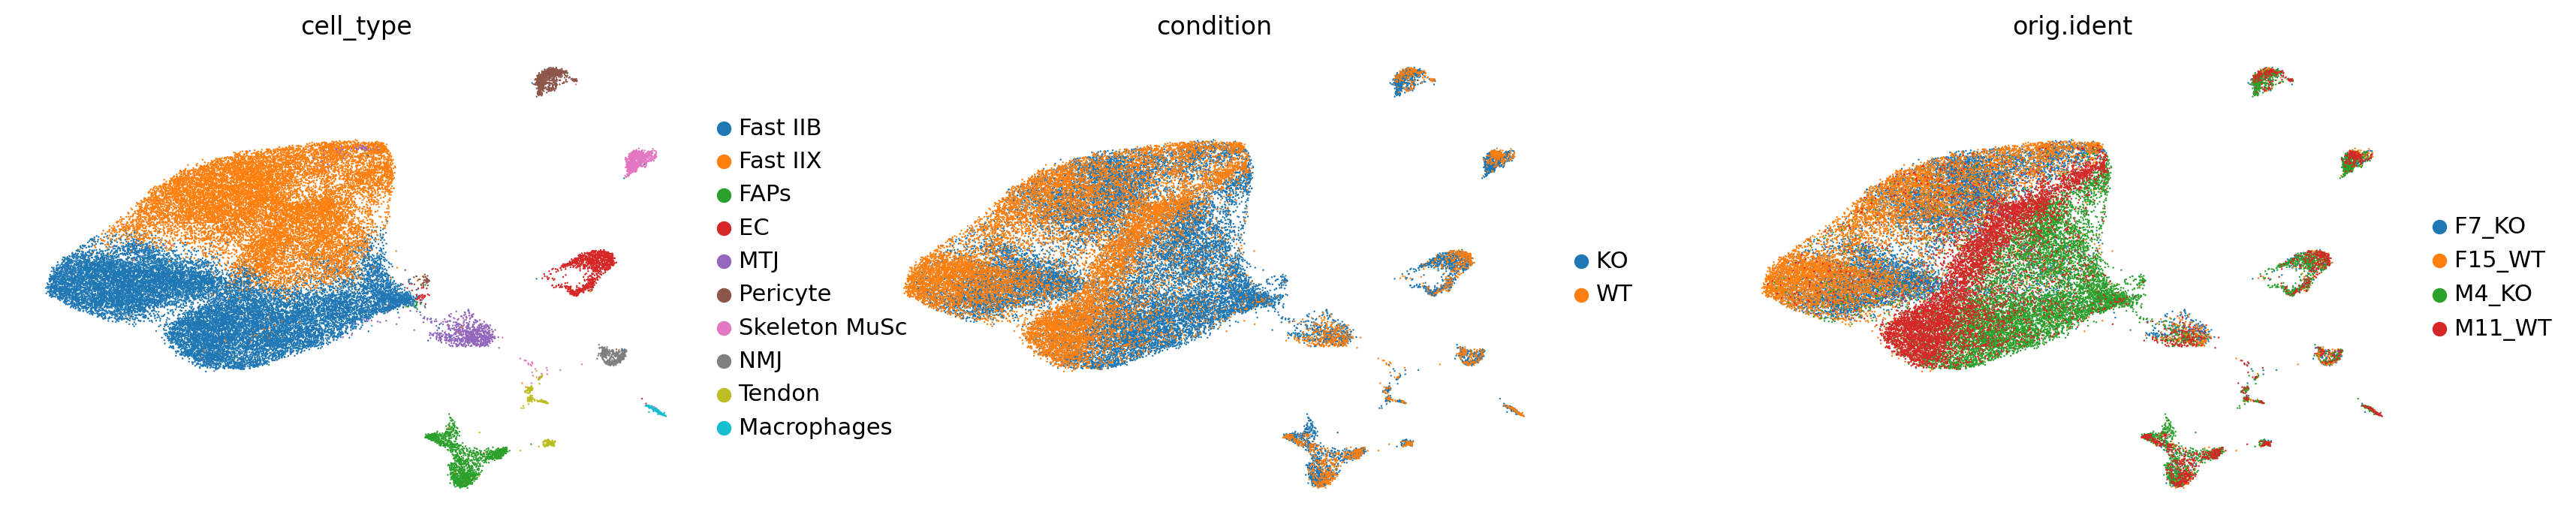

In [4]:
adata_rna = sc.read_h5ad(all_samples_path)
print(adata_rna)
#umap colors by both cell metadata and var.names (gene_names)
sc.pl.umap(adata_rna, color=['cell_type', 'condition', 'orig.ident'], frameon=False) 

#### Load loom files

In [5]:
# data directory and files for velocyto outputs
# sample_F7 (10,212)
data_dir_F7 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_F7/velocyto'
loom_file_F7 = os.path.join(data_dir_F7, 'aging_F7.loom')
# sample_F15 (9,716)
data_dir_F15 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_F15/velocyto'
loom_file_F15 = os.path.join(data_dir_F15, 'aging_F15.loom')
# sample M_4 (12,129)
data_dir_M4 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_M4/velocyto'
loom_file_M4 = os.path.join(data_dir_M4, 'aging_M4.loom')
# sample M_11 (8,239)
data_dir_M11 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_M11/velocyto'
loom_file_M11 = os.path.join(data_dir_M11, 'aging_M11.loom')

In [5]:
# Create an analysis object using loompy {gene by cell matrix}
ds = lp.connect(loom_file_M11)
print(ds.shape)
# List all available layers in the LayerManager object
print(ds.layers.keys())
# Global attributes
print(ds.attrs.keys())
# Obs for each gene and cell
print(ds.ra.keys()); print(ds.ca.keys())
# graphs if saved in the loom (most prob not)
ds.close() # at the end of the analysis so that the hdf5 is not corrputed


(32285, 8239)
['', 'ambiguous', 'spliced', 'unspliced']
['CreationDate', 'LOOM_SPEC_VERSION', 'velocyto.__version__', 'velocyto.logic']
['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand']
['CellID', 'Clusters']


#### Load created anndata with loomdata for all samples

In [17]:
# load the anndata object
adata_with_vcy_KO = sc.read_h5ad(os.path.join(data_dir, 'aging_all/objects/adata_plus_loom.h5ad'))

In [18]:
adata_with_vcy_KO

AnnData object with n_obs × n_vars = 22187 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'sample_batch', 'Clusters', '_X', '_Y', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'harmony', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'ambiguous', 'counts', 'matrix', 'spliced', 'unspliced'
    obsp: 'nn', 'snn'

In [ ]:
#subset anndata to male and female sample by orig.ident 
adata_KO_M = adata_with_vcy_KO[adata_with_vcy_KO.obs['orig.ident'].isin(['M_4', 'M_11'])]
adata_KO_F = adata_with_vcy_KO[adata_with_vcy_KO.obs['orig.ident'].isin(['F_7', 'F_15'])]


In [ ]:
adata_KO_M

In [ ]:
adata_KO_F

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


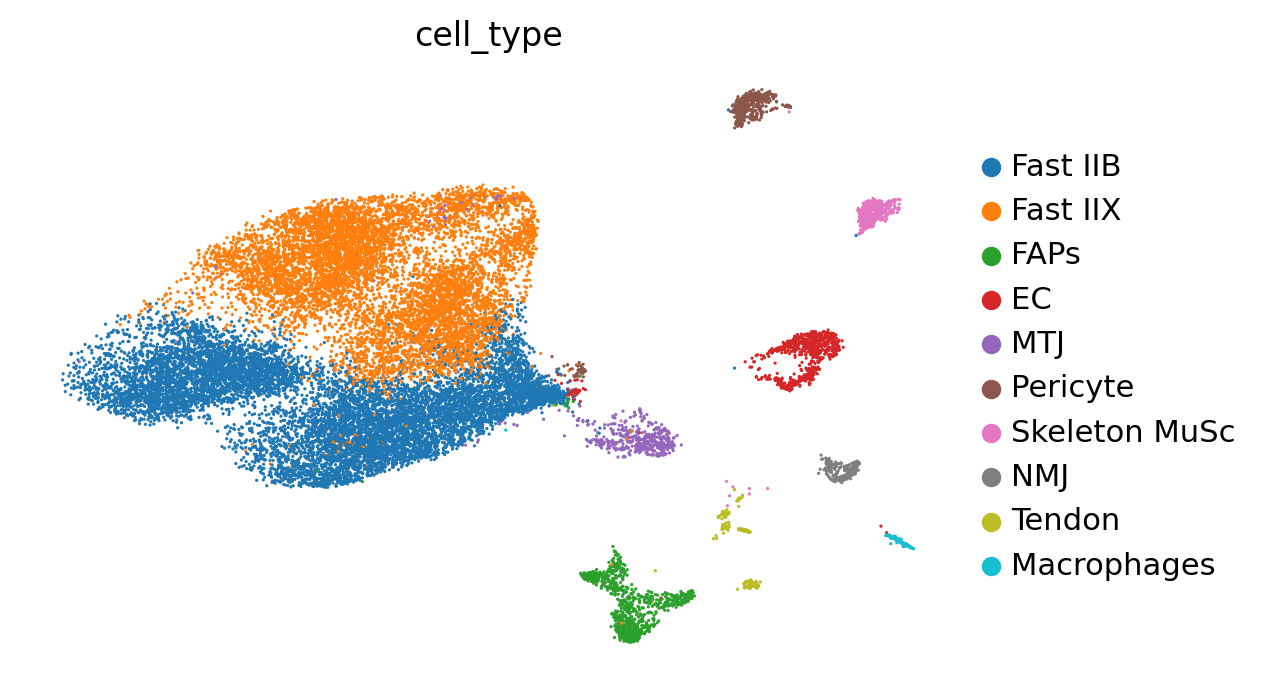

In [19]:
# plot umap to check
sc.pl.umap(adata_KO_F, color=['cell_type'], frameon=False)
sc.pl.umap(adata_KO_M, color=['cell_type'], frameon=False)

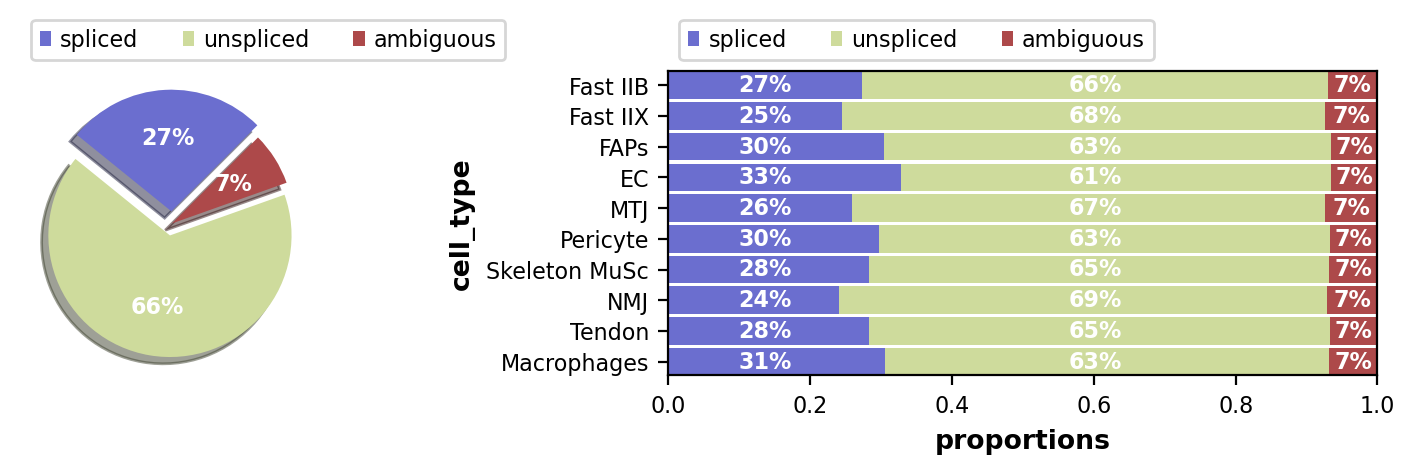

In [20]:
scv.pl.proportions(adata_with_vcy_KO, groupby='cell_type')

In [21]:
# pre-process the data
scv.pp.filter_and_normalize(adata_with_vcy_KO)
scv.pp.moments(adata_with_vcy_KO)

Normalized count data: spliced, unspliced.


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:14) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [22]:
# compute velocity
scv.tl.velocity(adata_with_vcy_KO, mode='stochastic')
scv.tl.velocity_graph(adata_with_vcy_KO)

computing velocities
    finished (0:00:28) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/128 cores)


  0%|          | 0/22187 [00:00<?, ?cells/s]

    finished (0:02:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


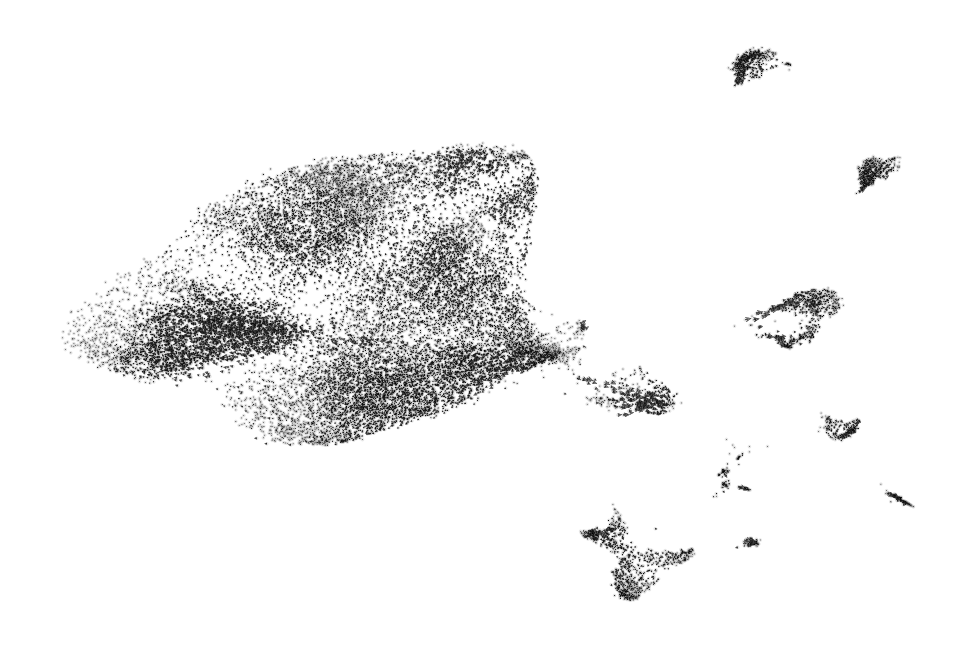

In [23]:
scv.pl.velocity_embedding(adata_with_vcy_KO, basis='umap', frameon=False)

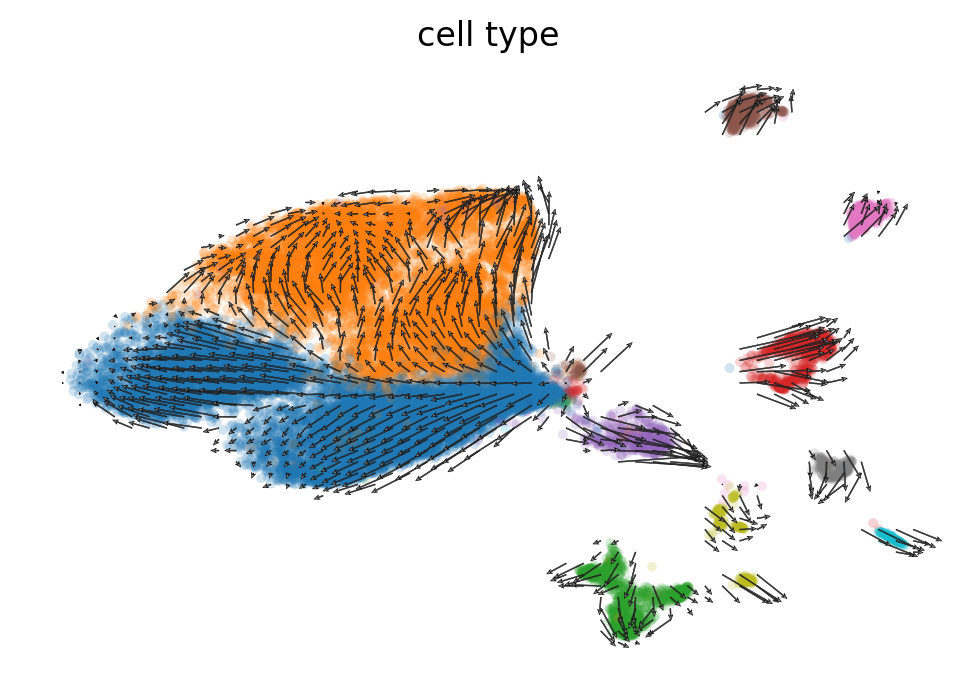

In [24]:
scv.pl.velocity_embedding_grid(adata_with_vcy_KO, basis='umap', color='cell_type', scale=0.25)

saving figure to file ./figures/scvelo_embedding_stream_KO.pdf


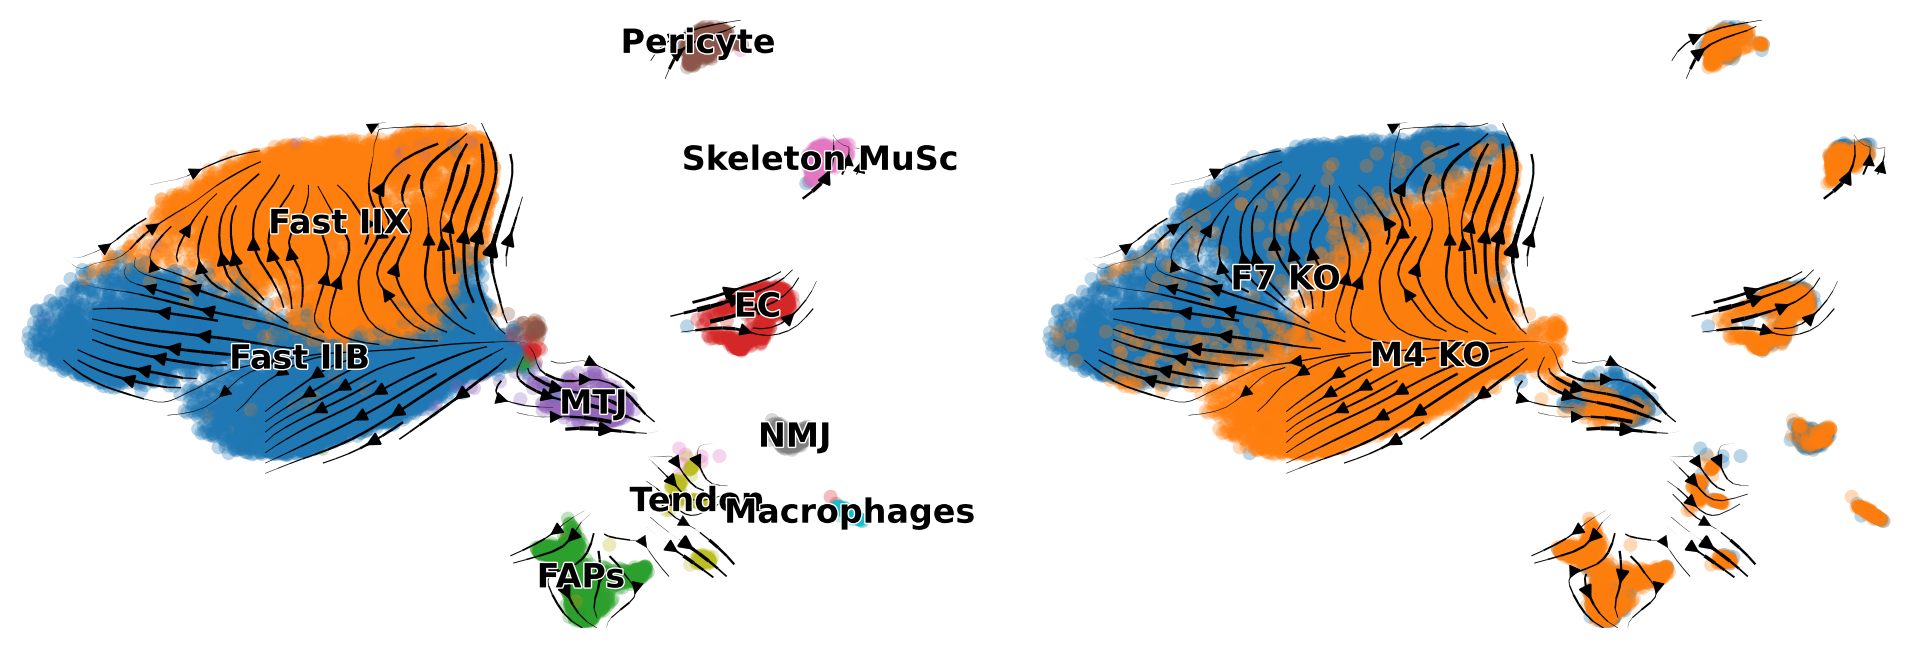

In [34]:
scv.pl.velocity_embedding_stream(adata_with_vcy_KO, basis='umap', color=['cell_type', 'orig.ident'], save='embedding_stream_KO.pdf', title='')

#### Pseudotime trajectory inference

In [26]:
scv.tl.rank_velocity_genes(adata_with_vcy_KO, groupby='cell_type', min_corr=.3)
#save dataframe csv
pd.DataFrame(adata_with_vcy_KO.uns["rank_velocity_genes"]["names"]).to_csv(os.path.join(data_dir, 'velocity_results/ranked_velocity_genes_KO.csv'))
print(pd.DataFrame(adata_with_vcy_KO.uns["rank_velocity_genes"]["names"]).head(10))


ranking velocity genes


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:01:10) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
  Fast IIB Fast IIX     FAPs       EC      MTJ Pericyte  Skeleton MuSc  \
0    Mylk4     Ank2    Slit3    Myo1d      App    Opcml           Ror1   
1    Phka1     Myh1    Man1a    Prex2  Ldlrad3    Ptprk         Sema6a   
2   Pfkfb3    Actn2  Runx1t1    Dock1     Rgcc    Pakap         Megf10   
3    Pde7a    Ppara   Plxdc2    Plcb4    Dapp1    Lin7a          Tshz3   
4      Pcx     Fgf1     Ebf2     Elk3    Lama2    Pde3a  2610307P16Rik   
5    Vldlr  Gm20757    Bicc1  Plekhg1    Pdzd2    Maml3           Bnc2   
6   Sorbs2    Lmcd1   Sh3d19   Ablim1   Usp6nl    Sgip1          Clcn5   
7   Ccdc60    Agbl1   Scara5   Lrrc8c     Scel    Asap2           Pax7   
8     Irs1     Ldhb     Egfr     Fli1   Pdlim3  Slc35f1          Ltbp1   
9    Tacc2     Nrp1   Antxr2     Rin3  Slc24a2   Inpp4b          Sytl2   

      NMJ   Tendon M

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


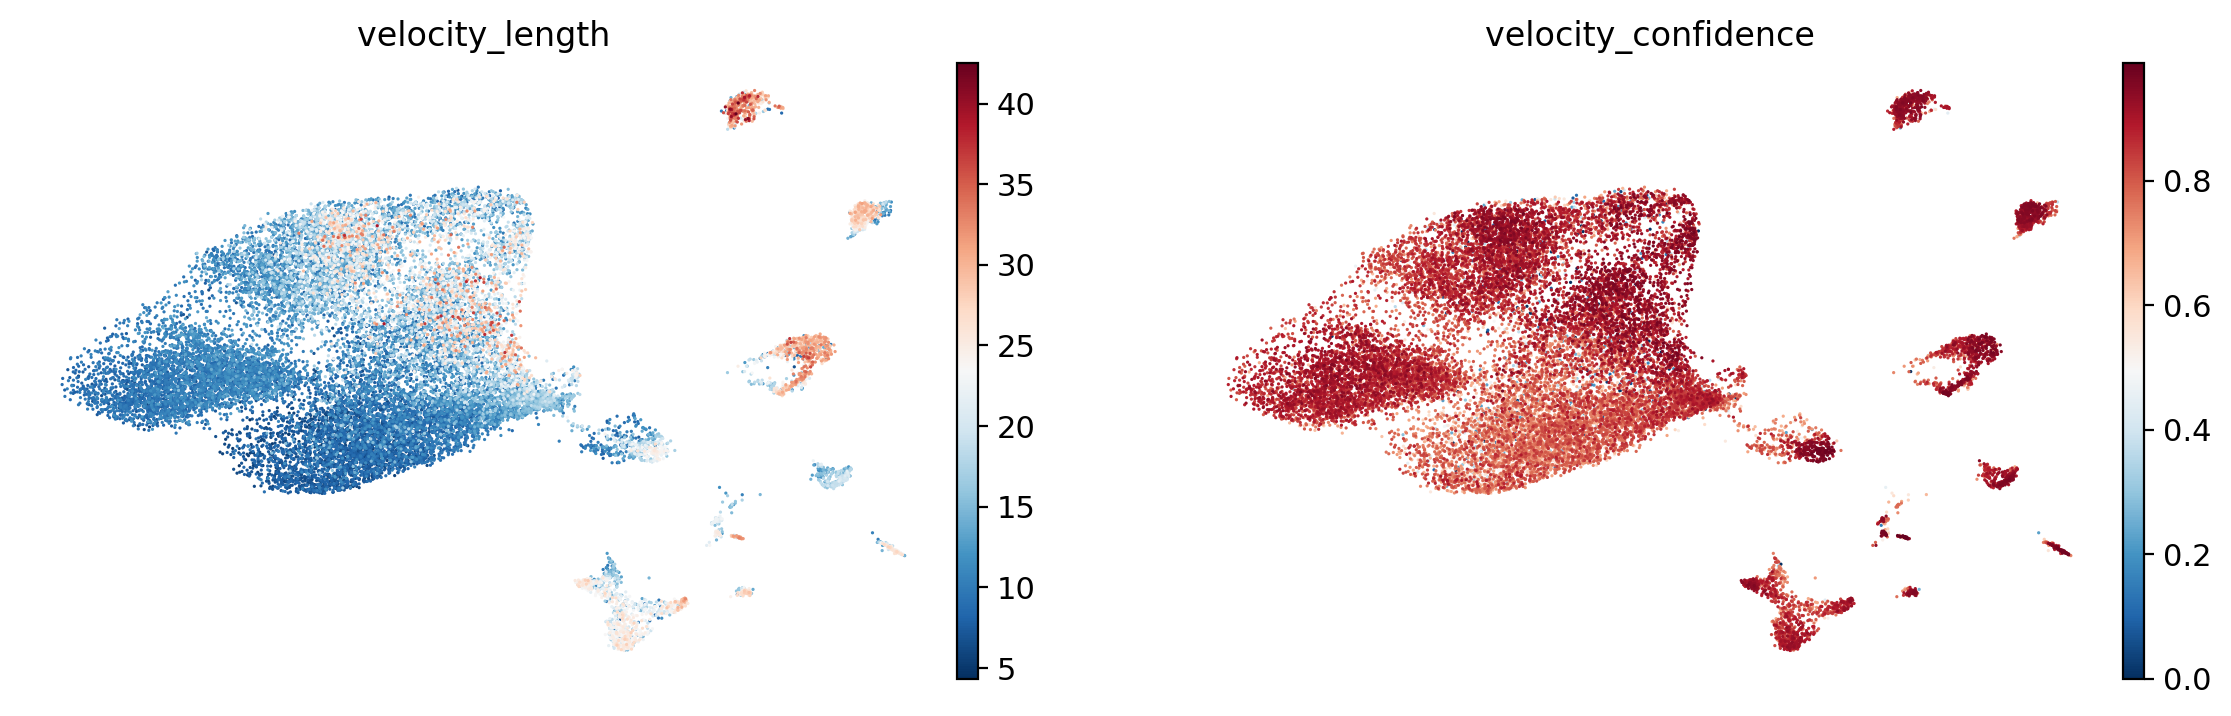

In [27]:
scv.tl.velocity_confidence(adata_with_vcy_KO)
# inspect velocity confidence
adata_with_vcy_KO.obs
# plot umap to check
sc.pl.umap(adata_with_vcy_KO, color=['velocity_length', 'velocity_confidence'], frameon=False, save='_velocity_confidence_KO.pdf')

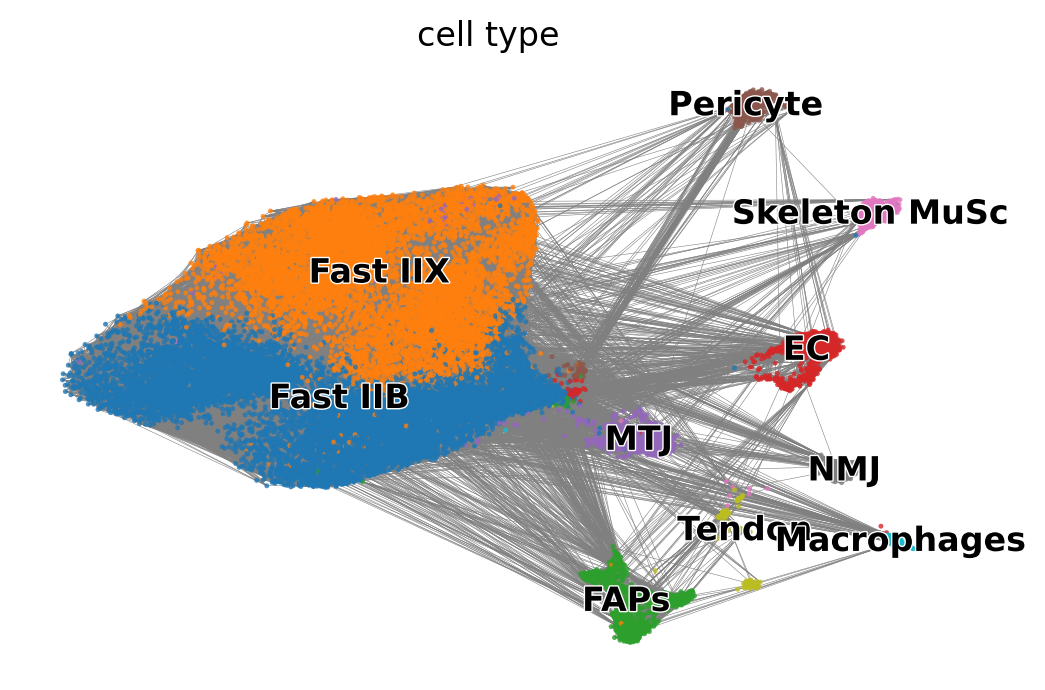

In [28]:
scv.pl.velocity_graph(adata_with_vcy_KO, threshold=.1, color='cell_type')

#### Get pseudo-time

In [29]:
scv.tl.velocity_pseudotime(adata_with_vcy_KO)
adata_with_vcy_KO.obs

computing terminal states
    identified 9 regions of root cells and 5 regions of end points .
    finished (0:00:07) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
AAACCCAAGATT      F7_KO      4350.0          1839    0.781609   
AAACCCACACTC      F7_KO      3258.0          1437    1.381215   
AAACCCACAGCC      F7_KO      5633.0          2080    0.479148   
AAACCCACAGTA      F7_KO      5423.0          2025    0.976778   
AAACCCACATCA      F7_KO      2051.0          1085    2.291565   
...                 ...         ...           ...         ...   
TTTGTTGTCATA      M4_KO      1408.0           837    1.774308   
TTTGTTGTCTAT      M4_KO      1052.0           601    5.608365   
TTTGTTGTCTGC      M4_KO      3571.0          1531    0.615901   
TTTGTTGTCTGT      M4_KO      5602.0          2018    0.410568   
TTTGTTGTCTTG      M4_KO      2765.0          1401    1.446132   

              log10GenesPerUMI seurat_clusters RNA_snn_res.0.6      cell_type  \
AAACCCAAGATT          0.897236               1               1       Fast IIX   
AAACCCACACTC          0.898805               0               0       Fast IIB   
AAACCCACAGCC          0.884717               1               1       Fast IIX   
AAACCCACAGTA          0.885550               1               1       Fast IIX   
AAACCCACATCA          0.916504               1               1       Fast IIX   
...                        ...             ...             ...            ...   
TTTGTTGTCATA          0.928335              11              11  Skeleton MuSc   
TTTGTTGTCTAT          0.919543               6               6       Fast IIB   
TTTGTTGTCTGC          0.896521               3               3       Fast IIB   
TTTGTTGTCTGT          0.881702               2               2       Fast IIX   
TTTGTTGTCTTG          0.914260               7               7           FAPs   

             condition  sample_batch  ... initial_size_spliced  initial_size  \
AAACCCAAGATT        KO  F7_KO_CGAA-1  ...                  852         852.0   
AAACCCACACTC        KO  F7_KO_ATAG-1  ...                  636         636.0   
AAACCCACAGCC        KO  F7_KO_TTCT-1  ...                 1308        1308.0   
AAACCCACAGTA        KO  F7_KO_TGAA-1  ...                 1095        1095.0   
AAACCCACATCA        KO  F7_KO_TTGG-1  ...                  573         573.0   
...                ...           ...  ...                  ...           ...   
TTTGTTGTCATA        KO  M4_KO_GGCT-1  ...                  283         283.0   
TTTGTTGTCTAT        KO  M4_KO_GCCC-1  ...                  390         390.0   
TTTGTTGTCTGC        KO  M4_KO_TGAA-1  ...                  980         980.0   
TTTGTTGTCTGT        KO  M4_KO_GCGG-1  ...                 1089        1089.0   
TTTGTTGTCTTG        KO  M4_KO_GCTC-1  ...                  614         614.0   

                 n_counts velocity_self_transition  velocity_length  \
AAACCCAAGATT  2843.131490                 0.247079             8.10   
AAACCCACACTC  2507.307482                 0.091037            12.24   
AAACCCACAGCC  2896.963229                 0.137425            12.55   
AAACCCACAGTA  2877.386157                 0.107121            17.01   
AAACCCACATCA  2184.379932                 0.166630            12.38   
...                   ...                      ...              ...   
TTTGTTGTCATA  1979.519737                 0.365582            25.74   
TTTGTTGTCTAT  1544.282679                 0.000000            12.12   
TTTGTTGTCTGC  2492.192249                 0.140514             8.74   
TTTGTTGTCTGT  2769.393978                 0.125296             8.77   
TTTGTTGTCTTG  2466.021987                 0.222704            11.35   

              velocity_confidence  velocity_confidence_transition  root_cells  \
AAACCCAAGATT             0.692314                        0.052306    0.000481   
AAACCCACACTC             0.773892                        0.414373    0.003016   
AAACCCACAGCC             0.103890                        0.104295    0.000868   
AAACCCACAGTA             0.859040                        0.242318    0.000797   
AAACCCACATCA             0.888006       

In [30]:
# this is needed due to a current bug - bugfix is coming soon.
adata_with_vcy_KO.uns['neighbors']['distances'] = adata_with_vcy_KO.obsp['distances']
adata_with_vcy_KO.uns['neighbors']['connectivities'] = adata_with_vcy_KO.obsp['connectivities']

In [31]:
scv.tl.paga(adata_with_vcy_KO, groups='cell_type')
df = scv.get_df(adata_with_vcy_KO, 'paga/transitions_confidence', precision=2).T

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:08) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_paga_velocity_cluster_movement_KO.pdf


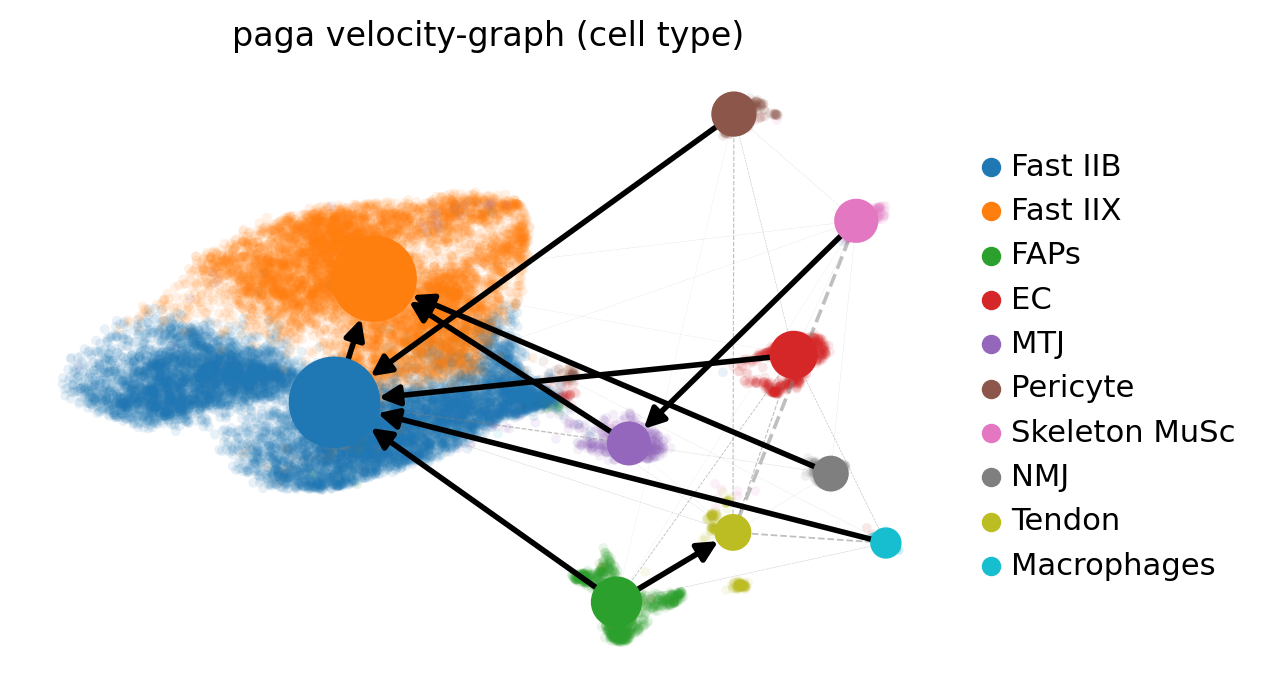

In [32]:
scv.pl.paga(adata_with_vcy_KO, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, save='paga_velocity_cluster_movement_KO.pdf')

In [33]:
#save new adata object with velocity calculated 
adata_with_vcy_KO.write(os.path.join(data_dir,'aging_all/objects/adata_with_vcy_KO.h5ad'))